In [1]:
import pandas as pd # used for managing the dataframes
import numpy as np # used for managing vectors and matrices
from wordcloud import WordCloud,STOPWORDS # for generating word clouds --> to show the most occuring words
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# graphing library
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
# NLTK libraries
import nltk
from nltk.corpus import stopwords

%matplotlib inline

In [2]:
train_set=pd.read_csv('train.csv')

In [3]:
train_set.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [4]:
train_set.shape

(38932, 5)

In [5]:
cnt_response = train_set["Is_Response"].value_counts()
trace1 = go.Bar(y=cnt_response.values,x=cnt_response.index,marker=dict(
        color = cnt_response.values,))
layout = go.Layout(
    title='Response Frequency'
)
data = [trace1]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="gender_freq")

In [7]:
cnt_browser = train_set["Browser_Used"].value_counts()
trace1 = go.Bar(y=cnt_browser.values,x=cnt_browser.index,marker=dict(
        color = cnt_browser.values,))
layout = go.Layout(
    title='Browser Frequency'
)
data = [trace1]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="browser_freq")

In [8]:
cnt_device = train_set["Device_Used"].value_counts()
labels = (np.array(cnt_device.index))
sizes = (np.array((cnt_device.values / cnt_device.values.sum())*100))
trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Device Usage distribution'
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="device_dist")

In [14]:
train_pos=train_set[train_set['Is_Response']=='happy']
train_neg=train_set[train_set['Is_Response']=='not happy']
train_pos=train_pos['Description']
train_neg=train_neg['Description']

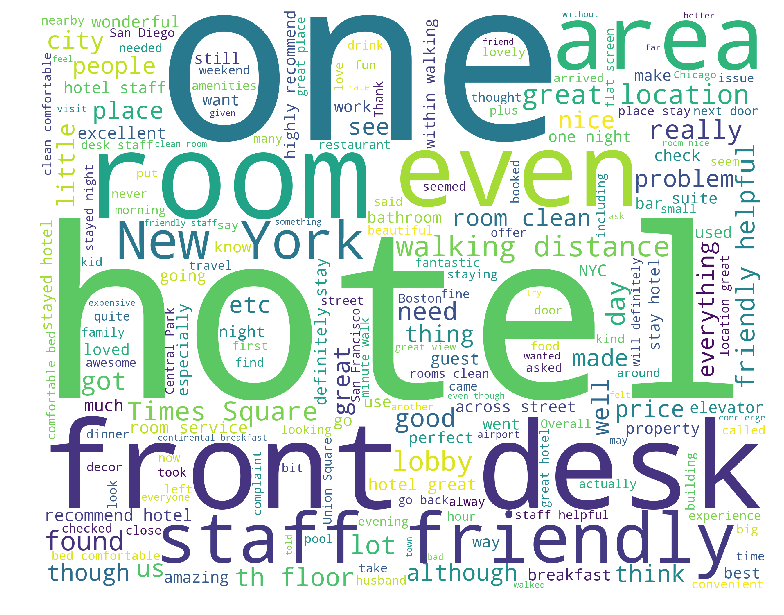

In [16]:
wc = WordCloud(stopwords=STOPWORDS,background_color='white',width=2500,height=2000).generate(" ".join(train_pos))
plt.figure(figsize=(13, 13))
plt.imshow(wc)
plt.axis('off')
plt.show()

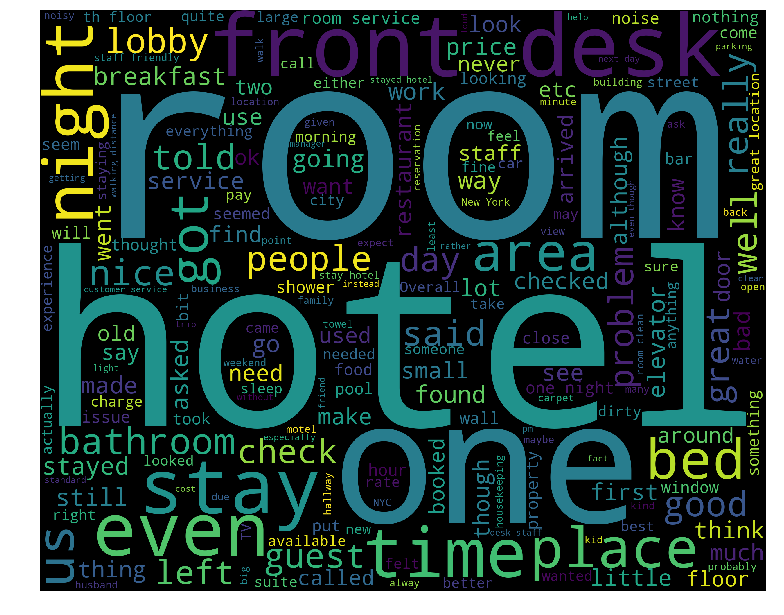

In [17]:
wc = WordCloud(stopwords=STOPWORDS,background_color='black',width=2500,height=2000).generate(" ".join(train_neg))
plt.figure(figsize=(13, 13))
plt.imshow(wc)
plt.axis('off')
plt.show()

## 2. Using TFLearn

In [19]:
import tflearn
from tflearn.data_utils import to_categorical,pad_sequences

In [29]:
# This function cleans the data and replace numbers by a common token: NUM. This function is inspired in kim's work
# at https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
import re
def clean_str(string):
    """
    Tokenization/string cleaning.
    """
    string = re.sub(r"[^A-Za-z0-9(),:!?\'\`]", " ", string)     
    string = re.sub(r"\'s", " \'s", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    string = re.sub(r",", " , ", string) 
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " \( ", string) 
    string = re.sub(r"\)", " \) ", string) 
    string = re.sub(r":", " : ", string)
    string = re.sub(r"\?", " \? ", string) 
    string = re.sub(r"\s{2,}", " ", string)
    string = string.strip().lower()
    string = re.sub(r"[0-9]{2,}", "NUM", string)
    return string

In [30]:
train_set["Cleaned_Description"]=train_set["Description"].apply(clean_str)

In [32]:
train_set.head() # cleaned the description

,User_ID,Description,Browser_Used,Device_Used,Is_Response,Cleaned_Description
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy,the room was kind of clean but had a very stro...
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy,"i stayed at the crown plaza april april , the ..."
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy,i booked this hotel through hotwire at the low...
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy,stayed here with husband and sons on the way t...
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy,my girlfriends and i stayed here to celebrate ...


In [33]:
from sklearn.feature_extraction.text import CountVectorizer

In [35]:
# this function will help in creating the tokenized Input Tensor 
vectorizer = CountVectorizer(stop_words='english',lowercase=False)

# fit the data
cleaned_description = vectorizer.fit(train_set["Cleaned_Description"])

# Get the vocabulary
vocabulary = cleaned_description.vocabulary_

# vocabulary is a dictionary with keys as the words and the values as frequencies
words = set(vocabulary.keys())

# Size of vocabulary
size_vocab = len(vocabulary)
print ("The vocabulary has {} words".format(size_vocab))

The vocabulary has 45634 words


In [38]:
# Get the data cleaned and transform words in numerical tokens.
text = train_set['Cleaned_Description'].tolist()
text = [string.split() for string in text]
# tokens is a list of lists. Each list inside tokens represents a sentence
tokens = []
for sentence in text:
    dummy = []
    for word in sentence:
        if word in words:
            dummy.append(vocabulary[word] + 1) # Sum 1 cause I want to leave the token 0 for padding in LSTM.
    tokens.append(dummy)
    
# Maximum length of a sentence in the data
max_len = max([len(sentence) for sentence in tokens])
print ("The largest sentence has {} tokens".format(max_len))

The largest sentence has 1056 tokens


In [61]:
X=tokens
train_set['Response']=train_set['Is_Response'].map({'happy':0,'not happy':1})
Y=train_set[['Response']]

In [62]:
X_train,X_val,Y_train,Y_val=train_test_split(X,Y,test_size=0.3,random_state=0,stratify=Y.Response)

In [63]:
# Sequence padding
trainX = pad_sequences(X_train, maxlen=max_len, value=0.) # max_len was found some cells above
validationX = pad_sequences(X_val, maxlen=max_len, value=0.)

# Converting labels to binary vectors
train_Y = to_categorical(Y_train.values, nb_classes=2)
val_Y = to_categorical(Y_val.values, nb_classes=2)

In [55]:
Y=to_categorical(train_set['Response'].values,nb_classes=2)

In [ ]:
# the sentences are not of equal length hence they have to be padded with zeros